# Auto Significance Testing

In [ ]:
# cbcbc
Things To Improve

-- Hypothesis test - categorical, sample average against the population mean
-- 1 tail, 2 tail 
x- More thorough visualization/exploration of the data
x- Pull more of the functions apart
-- More automation
-- Independence of observations, no autocorrelation
-- ANOVA/MANOVA
-- Implement this logic flow, with assumption checking at each and every step, https://python.plainenglish.io/statistical-tests-with-python-880251e9b572
-- Statistical tests focused on A/A tests
x- Transformations to normality 
-- https://www.intro2r.info/unit3/which-test.html

In [266]:
#Helper functions
from statsmodels.stats import weightstats as stests
from scipy.stats import shapiro,ttest_ind,skew,kurtosis,probplot
from matplotlib import pyplot as plt
import numpy as np
import scipy as scipy
    

# identify outliers using simple interquartile ranges
def iqr_outlier(x,threshold):
    import numpy as np
    sorted(x)
    Q1,Q3 = np.percentile(x,[25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (threshold * IQR)
    upper_range = Q3 + (threshold * IQR)
    output = [i for i in x if i < lower_range or i > upper_range]
    if len(output) > 0:
        print(len(outliers),' outlier/s detected (Using IQR). This can cuase accuracy issues with normality transformations')
    else:
        print('Sample is outlier free (Using IQR)')
    print()
    return output
    

# test normality of sample
def norm_test(x,alpha):
    #Plot the data
    plt.style.use('ggplot')
    plt.hist(x,bins='auto') 
    plt.title('Sample Histogram')
    plt.ylabel('Frequency')
    plt.show()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    #ax1.set_xlabel('')
    ax1.set_title('Probality plot against normal distribution')
    plt.show()
    
    #Skewness & Kurtosis test
    print('---Sample distribution----------------------')
    kurt = kurtosis(x)
    skewness = skew(x)
    print( 'Kurtosis (Normal dist. = 0): {}'.format(kurt))
    print( 'Skewness (Normal dist. = 0): {}'.format(skewness))
    print()
    
    #Normality test
    stat_x, p_x = shapiro(x)
    print('Normality statistics =%.3f, p=%.3f' % (stat_x, p_x))
    print('Gaussian (fail to reject H0)') if p_x > alpha else print('non-Gaussian (reject H0)')
    print()
    if p_x > alpha:
        dist = 'gaussian'
    else: 
        dist = 'non-gaussian'
    return dist
    
#Equality of variance test
def var_test(x,y,alpha):
    print('---Variance equality test -----------------------')
    x_var = np.array(x)
    y_var = np.array(y)
    f = np.var(x_var, ddof=1)/np.var(y_var, ddof=1) #calculate F test statistic 
    dfn = x_var.size-1 #define degrees of freedom numerator 
    dfd = y_var.size-1 #define degrees of freedom denominator 
    f_test_p_value = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    if f_test_p_value < alpha:
        variance = 'unequal'
    else:
        variance = 'equal'
    print('f test p-value =', f_test_p_value)
    print('Variance <> equal') if f_test_p_value < alpha else print('Variance = equal')
    print()
    return variance

#Statistical tests
def two_sample_ztest(x,y,alpha,x_normality,y_normality):
    print('--Z Test----------------------------------------------')
    print('Sample sizes might be too small to run a z test. x =%.f, y =%.f' % (len(x),len(y))) if len(x) < 30 or len(y) < 30 else print('Sample large enough for z test. x =%.f, y =%.f' % (len(x),len(y)))
    print('Some assumptions have violated for this test, see above') if x_normality == 'non-gaussian' or y_normality == 'non-gaussian'  else print('Assumptions are met, but its always better to check yourself')
    ztest ,pval_z = stests.ztest(x, y, value=0,alternative='two-sided')  
    print('Reject H0, significant difference exists, p value = %.3f' % (pval_z)) if pval_z < alpha else print('Fail to reject H0, no statistical difference between samples, p value = %.3f' % (pval_z))
    print()

def two_sample_ttest(x,y,alpha,x_normality,y_normality,variance):
    print('--T Test---------------------------------------------')
    print('T Test with unequal variance') if variance == 'unequal' else print('T Test with equal variance')
    print('Some assumptions have been violated for this test, see above') if x_normality == 'non-gaussian' or y_normality== 'non-gaussian' else print('Assumptions are met, but its always better to check yourself')
    if variance == 'unequal':
        t, pval_t = ttest_ind(x, y, equal_var=False)
    else:
        t, pval_t = ttest_ind(x, y, equal_var=True)
    print('T statistic =',t)
    print('Reject H0, significant difference exists, p value = %.3f' % (pval_t)) if pval_t < alpha else print('Fail to reject H0, no statistical difference between samples, p value = %.3f' % (pval_t))
    print()
    
def two_sample_mwutest(x,y,alpha):
    print('--Mann-Whitney U Test (Nonparametric)-----------------')
    print('Sample sizes might be too small to run a mwu test. x =%.f, y =%.f' % (len(x),len(y))) if len(x) < 20 or len(y) < 20 else print('Sample large enough for mwu test. x =%.f, y =%.f' % (len(x),len(y)))
    stat_mw, p_mw = scipy.stats.mannwhitneyu(x, y)
    print('MWU statistics = %.3f, p=%.3f' % (stat_mw, p_mw))
    print('Reject H0, significant difference exists, p value = %.3f' % (p_mw)) if p_mw < alpha else print('Fail to reject H0, no statistical difference between samples, p value = %.3f' % (p_mw))

#YJ normality transformation
def power_transform(x,y):
    skew_x = skew(x)
    skew_y = skew(y)
    pt_x_output, pt_x_lambda = stats.yeojohnson(x)
    pt_y_output, pt_y_lambda = stats.yeojohnson(y)
    if skew_x > skew_y:
        x_transform = stats.yeojohnson(x,pt_x_lambda)
        y_transform = stats.yeojohnson(y,pt_x_lambda)
    else:
        x_transform = stats.yeojohnson(x,pt_y_lambda)
        y_transform = stats.yeojohnson(y,pt_y_lambda)
    return x_transform, y_transform   
 
#Output general info of sign. test
def sign_cont_two_sample(x,y,alpha,transform=None):
    if transform == 1:
        x,y  = power_transform(x,y)
        
    print('--1st Sample------------------------------------------')
    x_norm = norm_test(x,alpha)
    iqr_outlier(x,1.5)
    print('--2nd Sample------------------------------------------')
    y_norm = norm_test(y,alpha)
    iqr_outlier(y,1.5)
    print('--Variance test---------------------------------------')
    var_output = var_test(x,y,alpha)
    
    #Statistical Tests
    two_sample_ztest(x,y,alpha,x_norm,y_norm)
    two_sample_ttest(x,y,alpha,var_output,x_norm,y_norm)
    two_sample_mwutest(x,y,alpha)


    

--1st Sample------------------------------------------


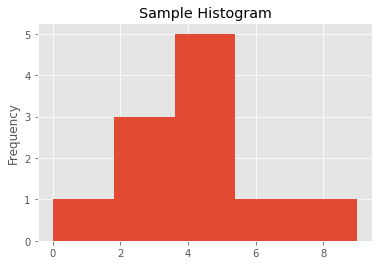

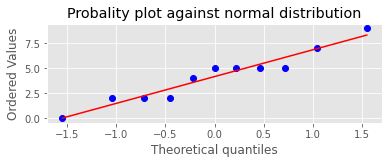

---Sample distribution----------------------
Kurtosis (Normal dist. = 0): -0.5038827203597265
Skewness (Normal dist. = 0): 0.20041049462409247

Normality statistics =0.945, p=0.580
Gaussian (fail to reject H0)

Sample is outlier free (Using IQR)

--2nd Sample------------------------------------------


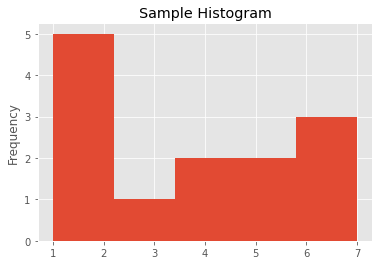

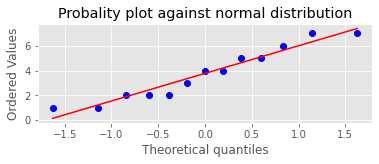

---Sample distribution----------------------
Kurtosis (Normal dist. = 0): -1.2606111918079748
Skewness (Normal dist. = 0): 0.2050228320706586

Normality statistics =0.921, p=0.256
Gaussian (fail to reject H0)

Sample is outlier free (Using IQR)

--Variance test---------------------------------------
---Variance equality test -----------------------
f test p-value = 0.26749837480771255
Variance = equal

--Z Test----------------------------------------------
Sample sizes might be too small to run a z test. x =11, y =13
Assumptions are met, but its always better to check yourself
Fail to reject H0, no statistical difference between samples, p value = 0.666

--T Test---------------------------------------------
T Test with equal variance
Assumptions are met, but its always better to check yourself
T statistic = 0.43132074551306965
Fail to reject H0, no statistical difference between samples, p value = 0.670

--Mann-Whitney U Test (Nonparametric)-----------------
Sample sizes might be too s

In [276]:
x = [0,4,5,5,5,5,9,2,2,2,7]
y = [1,2,3,4,5,6,7,4,2,2,5,7,1]
alpha = 0.05
sign_cont_two_sample(x,y,alpha,transform=0)

In [233]:
import statistics  
print(statistics.mean(power_transform(x)))
print(statistics.mean(power_transform(y)))
#Test again for normality

3.0991925370876547
2.0477670133153314


In [260]:
power_transform(x,y)

(array([0.        , 3.09040253, 3.73095113, 3.73095113, 3.73095113,
        3.73095113, 6.06106737, 1.6937653 , 1.6937653 , 1.6937653 ,
        4.93454758]),
 array([0.90511347, 1.6937653 , 2.41518322, 3.09040253, 3.73095113,
        4.34403478, 4.93454758, 3.09040253, 1.6937653 , 6.06106737,
        6.06106737, 6.06106737, 1.6937653 , 3.73095113, 4.93454758,
        0.90511347, 5.50601069, 0.90511347, 0.90511347]))